<center><img src="https://raw.githubusercontent.com/EO-College/cubes-and-clouds/main/icons/cnc_3icons_process_circle.svg"
     alt="Cubes & Clouds logo"
     style="float: center; margin-right: 10px; margin-left: 10px; max-height: 250px;" /></center>

# 2.3 Data Access and Basic Processing

<img src="https://openeo.org/images/openeo_logo.png"
     alt="openEO logo"
     style="float: center; margin-right: 10px; max-height: 100px;"/>
     
## Aggregate Operators with openEO

### `aggregate_temporal_period`: temporal aggregation with predefined intervals

Start importing the necessary libraries and initialize a local connection for Client-Side Processing.

In [1]:
import openeo
from openeo.local import LocalConnection
local_conn = LocalConnection('')

Create the starting Sentinel-2 datacube:

In [2]:
url = "https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a"

spatial_extent = {"west": 11.4, "east": 11.42, "south": 45.5, "north": 45.52}
temporal_extent = ["2020-01-01", "2020-12-31"]
bands = ["red","green","blue"]
properties = {"eo:cloud_cover": dict(lt=50)}

s2_cube = local_conn.load_stac(url=url,
   spatial_extent=spatial_extent,
   temporal_extent=temporal_extent,
   bands=bands,
   properties=properties
)
s2_cube.execute()

<xarray.DataArray 'stackstac-587a041b17fb7c9cd87a642a8d07f1b6' (time: 91,
                                                                band: 3,
                                                                y: 227, x: 163)> Size: 81MB
dask.array<getitem, shape=(91, 3, 227, 163), dtype=float64, chunksize=(1, 1, 227, 163), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 728B 2020-...
    id                                       (time) <U24 9kB 'S2A_32TPR_20200...
  * band                                     (band) <U5 60B 'red' 'green' 'blue'
  * x                                        (x) float64 1kB 6.874e+05 ... 6....
  * y                                        (y) float64 2kB 5.044e+06 ... 5....
    s2:water_percentage                      (time) float64 728B 2.998 ... 2.354
    ...                                       ...
    proj:transform                           object 8B {0, 5100000, 600000, 1...
    title                                    (band) <U20 240B 'Red (band 4) -...
    common_name                              (band) <U5 60B 'red' 'green' 'blue'
    center_wavelength                        (band) float64 24B 0.665 0.56 0.49
    full_width_half_max                      (band) float64 24B 0.038 ... 0.098
    epsg                                     int64 8B 32632
Attributes:
    spec:        RasterSpec(epsg=32632, bounds=(600000.0, 4990200.0, 709800.0...
    crs:         epsg:32632
    transform:   | 10.00, 0.00, 600000.00|\n| 0.00,-10.00, 5100000.00|\n| 0.0...
    resolution:  10.0

We might be interested in aggregating our data over periods like week, month, year etc., defining what operation to use to combine the data available in the chosen period.

Using `aggregate_temporal_period` we can achieve this easily:

In [3]:
s2_monthly_min = s2_cube.aggregate_temporal_period(period="month",reducer="min")
s2_monthly_min

Check what happens to the datacube inspecting the resulting xArray object. Now the `time` dimension has 12 labels, one for each month.

In [4]:
s2_monthly_min.execute()

/home/conda/cubes-and-clouds/c5700e54f9bf0cac112de5ad98df11ba8c1a388a721f96681ed5ec2c7cf9fb10-20250428-084028-259987-587-cubes_and_clouds_update/lib/python3.11/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


<xarray.DataArray 'stackstac-587a041b17fb7c9cd87a642a8d07f1b6' (time: 12,
                                                                band: 3,
                                                                y: 227, x: 163)> Size: 11MB
dask.array<stack, shape=(12, 3, 227, 163), dtype=float64, chunksize=(1, 1, 227, 163), chunktype=numpy.ndarray>
Coordinates: (12/22)
  * band                                     (band) <U5 60B 'red' 'green' 'blue'
  * x                                        (x) float64 1kB 6.874e+05 ... 6....
  * y                                        (y) float64 2kB 5.044e+06 ... 5....
    instruments                              <U3 12B 'msi'
    grid:code                                <U10 40B 'MGRS-32TPR'
    s2:saturated_defective_pixel_percentage  int64 8B 0
    ...                                       ...
    title                                    (band) <U20 240B 'Red (band 4) -...
    common_name                              (band) <U5 60B 'red' 'green' 'blue'
    center_wavelength                        (band) float64 24B 0.665 0.56 0.49
    full_width_half_max                      (band) float64 24B 0.038 ... 0.098
    epsg                                     int64 8B 32632
  * time                                     (time) datetime64[ns] 96B 2020-0...
Attributes:
    spec:        RasterSpec(epsg=32632, bounds=(600000.0, 4990200.0, 709800.0...
    crs:         epsg:32632
    transform:   | 10.00, 0.00, 600000.00|\n| 0.00,-10.00, 5100000.00|\n| 0.0...
    resolution:  10.0

### `aggregate_spatial`: spatial aggregation with geometries

Before performing the operation on the satellite data with openEO, we need to get a vector data to be used in our workflow.

We will use the city boundaries of Bolzano (Italy) to perform an aggregation of the pixels within the specified geometry.

The geometry will be loaded from a public geoJSON file containing the boundaries of all the italian municipalities.

In [5]:
import geopandas as gpd

italian_municipalities = gpd.read_file("https://raw.githubusercontent.com/openpolis/geojson-italy/refs/heads/master/comuni.geojson")
italian_municipalities.head()

,name,op_id,name_de,name_sl,minint_elettorale,minint_finloc,name_it,prov_name,prov_istat_code,prov_istat_code_num,prov_acr,reg_name,reg_istat_code,reg_istat_code_num,opdm_id,com_catasto_code,com_istat_code,com_istat_code_num,geometry
0,Agliè,130,None,None,1010810010,1010810010,None,Torino,001,1,TO,Piemonte,01,1,1,A074,001001,1001,"MULTIPOLYGON (((7.78266 45.38717, 7.79106 45.3..."
1,Airasca,131,None,None,1010810020,1010810020,None,Torino,001,1,TO,Piemonte,01,1,2,A109,001002,1002,"MULTIPOLYGON (((7.48795 44.93917, 7.49307 44.9..."
2,Ala di Stura,132,None,None,1010810030,1010810030,None,Torino,001,1,TO,Piemonte,01,1,3,A117,001003,1003,"MULTIPOLYGON (((7.27324 45.33927, 7.27360 45.3..."
3,Albiano d'Ivrea,133,None,None,1010810040,1010810040,None,Torino,001,1,TO,Piemonte,01,1,4,A157,001004,1004,"MULTIPOLYGON (((7.92507 45.44821, 7.92682 45.4..."
4,Almese,135,None,None,1010810060,1010810060,None,Torino,001,1,TO,Piemonte,01,1,6,A218,001006,1006,"MULTIPOLYGON (((7.43490 45.13442, 7.43524 45.1..."


We select the row corresponding to Bolzano and plot it with a base layer:

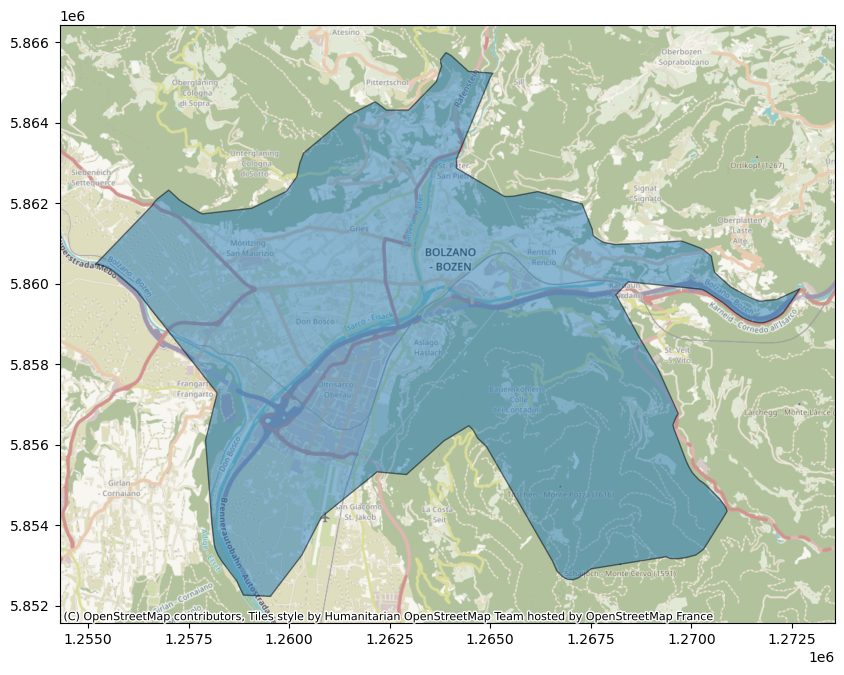

In [6]:
import contextily as cx

bz_geom = italian_municipalities.loc[italian_municipalities["name"] == "Bolzano/Bozen"]

bz_wm = bz_geom.to_crs(epsg=3857)
ax = bz_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
cx.add_basemap(ax)

We can now build our workflow with openEO, starting to load some Sentinel-2 data from STAC as before:

In [7]:
url = "https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a"

spatial_extent = {"west": 11.25, "east": 11.44, "south": 46.4, "north": 46.6}
temporal_extent = ["2020-01-01", "2020-12-31"]
bands = ["red"]
properties = {"eo:cloud_cover": dict(lt=15),
             "earthsearch:boa_offset_applied": dict(eq=True)}

s2_cube = local_conn.load_stac(url=url,
   spatial_extent=spatial_extent,
   temporal_extent=temporal_extent,
   bands=bands,
   properties=properties
)

Now we call the `aggregate_spatial` process and compute the average over the Sentinel-2 pixels inside the city.

**Running this cell may take up to 2 minutes**

In [8]:
bolzano_mean_xr = s2_cube.aggregate_spatial(
    geometries=bz_geom.geometry.values[0].geoms[0],
    reducer="mean").execute()

bolzano_mean_xr

<xarray.DataArray 'stackstac-2622c14711d60721e08f0659e8a41745' (geometry: 1,
                                                                time: 54,
                                                                band: 1)> Size: 432B
dask.array<broadcast_to, shape=(1, 54, 1), dtype=float64, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 432B 2020-...
    id                                       (time) <U24 5kB 'S2A_32TPS_20200...
  * band                                     (band) <U3 12B 'red'
    s2:water_percentage                      (time) float64 432B 0.3817 ... 0...
    s2:product_uri                           (time) <U65 14kB 'S2A_MSIL2A_202...
    updated                                  (time) <U24 5kB '2023-10-22T21:3...
    ...                                       ...
    proj:shape                               object 8B {10980}
    common_name                              <U3 12B 'red'
    center_wavelength                        float64 8B 0.665
    full_width_half_max                      float64 8B 0.038
    epsg                                     int64 8B 32632
  * geometry                                 (geometry) object 8B POLYGON ((6...
Indexes:
    geometry  GeometryIndex (crs=EPSG:32632)
Attributes:
    spec:        RasterSpec(epsg=32632, bounds=(600000.0, 5090220.0, 709800.0...
    crs:         epsg:32632
    transform:   | 10.00, 0.00, 600000.00|\n| 0.00,-10.00, 5200020.00|\n| 0.0...
    resolution:  10.0

Finally, we can plot the resulting time series of values for a sample band:

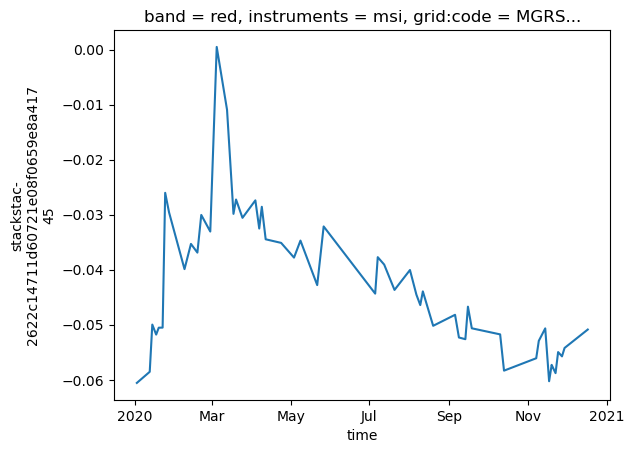

In [9]:
bolzano_mean_xr[:,:,0].plot()